In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

## Functions

In [2]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [3]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [4]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(width),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [5]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,fe_s,fe_index,fe_shift,sb_s,sb_index,sb_shift,\
                         bc_s,bc_index,bc_shift,bh_s,bh_index,bh_shift,\
                         o3l1_f,o3l1_cent,o3l1_fwhm,\
                         o3l2_f,o3l2_cent,o3l2_fwhm,\
                         o3s1_f,o3s1_cent,o3s1_fwhm,\
                         o3s2_f,o3s2_cent,o3s2_fwhm,\
                         hbn1_f,hbn1_cent,hbn1_fwhm,\
                         hbn2_f,hbn2_cent,hbn2_fwhm,\
                         hbb1_f,hbb1_cent,hbb1_fwhm,\
                         hbb2_f,hbb2_cent,hbb2_fwhm,\
                         hbb3_f,hbb3_cent,hbb3_fwhm,\
                         hgb1_f,hgb1_cent,hgb1_fwhm,\
                         hgb2_f,hgb2_cent,hgb2_fwhm,\
                         hdb1_f,hdb1_cent,hdb1_fwhm,\
                         hdb2_f,hdb2_cent,hdb2_fwhm,\
                         heb1_f,heb1_cent,heb1_fwhm,\
                         heb2_f,heb2_cent,heb2_fwhm,\
                         s21_f,s21_cent,s21_fwhm,\
                         s22_f,s22_cent,s22_fwhm,\
                         ne3s1_f,ne3s1_cent,ne3s1_fwhm,\
                         ne3s2_f,ne3s2_cent,ne3s2_fwhm,\
                         ne3l1_f,ne3l1_cent,ne3l1_fwhm,\
                         ne3l2_f,ne3l2_cent,ne3l2_fwhm,\
                         o2s1_f,o2s1_cent,o2s1_fwhm,\
                         o2s2_f,o2s2_cent,o2s2_fwhm,\
                         o2l1_f,o2l1_cent,o2l1_fwhm,\
                         o2l2_f,o2l2_cent,o2l2_fwhm,\
                         ne5s1_f,ne5s1_cent,ne5s1_fwhm,\
                         ne5s2_f,ne5s2_cent,ne5s2_fwhm,\
                         ne5l1_f,ne5l1_cent,ne5l1_fwhm,\
                         ne5l2_f,ne5l2_cent,ne5l2_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)  
    
    # optical Fe II template
    feii = template_fitter(x,feii_templates,fe_s,fe_index,fe_shift)
    
    # MILES stellar template
    sb = template_fitter(x,stellar_templates,sb_s,sb_index,sb_shift)
    
    # balmer continuum
    bc = template_fitter(x,balmer_cont_templates,bc_s,bc_index,bc_shift)
    
    # high-order Balmers lines (n=8+)
    ho = template_fitter(x,balmer_highorder_templates,bh_s,bh_index,bh_shift)
    
    # [O III] 5007
    o3l1 = gaussian(x,o3l1_f,o3l1_cent,o3l1_fwhm,normalized=False)
    o3l2 = gaussian(x,o3l2_f,o3l2_cent,o3l2_fwhm,normalized=False)
    
    # [O III] 4959
    o3s1 = gaussian(x,o3s1_f,o3s1_cent,o3s1_fwhm,normalized=False)
    o3s2 = gaussian(x,o3s2_f,o3s2_cent,o3s2_fwhm,normalized=False)  
    
    # narrow Hbeta
    hbn1 = gaussian(x,hbn1_f,hbn1_cent,hbn1_fwhm,normalized=False)
    hbn2 = gaussian(x,hbn2_f,hbn2_cent,hbn2_fwhm,normalized=False)  
    
    # broad Hbeta
    hbb1 = gaussian(x,hbb1_f,hbb1_cent,hbb1_fwhm,normalized=False)      
    hbb2 = gaussian(x,hbb2_f,hbb2_cent,hbb2_fwhm,normalized=False) 
    hbb3 = gaussian(x,hbb3_f,hbb3_cent,hbb3_fwhm,normalized=False) 
    
    # broad Hgamma
    hgb1 = gaussian(x,hgb1_f,hgb1_cent,hgb1_fwhm,normalized=False)      
    hgb2 = gaussian(x,hgb2_f,hgb2_cent,hgb2_fwhm,normalized=False) 
    
    # broad Hdelta
    hdb1 = gaussian(x,hdb1_f,hdb1_cent,hdb1_fwhm,normalized=False)
    hdb2 = gaussian(x,hdb2_f,hdb2_cent,hdb2_fwhm,normalized=False)
    
    # broad Hepsilon
    heb1 = gaussian(x,heb1_f,heb1_cent,heb1_fwhm,normalized=False)
    heb2 = gaussian(x,heb2_f,heb2_cent,heb2_fwhm,normalized=False)
    
    # narrow [S II] 4072
    s21 = gaussian(x,s21_f,s21_cent,s21_fwhm,normalized=False)
    s22 = gaussian(x,s22_f,s22_cent,s22_fwhm,normalized=False)
    
    # narrow [Ne III] 3869
    ne3s1 = gaussian(x,ne3s1_f,ne3s1_cent,ne3s1_fwhm,normalized=False)
    ne3s2 = gaussian(x,ne3s2_f,ne3s2_cent,ne3s2_fwhm,normalized=False)
    
    # narrow [Ne III] 3967
    ne3l1 = gaussian(x,ne3l1_f,ne3l1_cent,ne3l1_fwhm,normalized=False)
    ne3l2 = gaussian(x,ne3l2_f,ne3l2_cent,ne3l2_fwhm,normalized=False)
    
    # narrow [O II] 3726
    o2s1 = gaussian(x,o2s1_f,o2s1_cent,o2s1_fwhm,normalized=False)
    o2s2 = gaussian(x,o2s2_f,o2s2_cent,o2s2_fwhm,normalized=False)
    
    # narrow [O II] 3729
    o2l1 = gaussian(x,o2l1_f,o2l1_cent,o2l1_fwhm,normalized=False)
    o2l2 = gaussian(x,o2l2_f,o2l2_cent,o2l2_fwhm,normalized=False)
    
    # narrow [Ne V] 3346
    ne5s1 = gaussian(x,ne5s1_f,ne5s1_cent,ne5s1_fwhm,normalized=False)
    ne5s2 = gaussian(x,ne5s2_f,ne5s2_cent,ne5s2_fwhm,normalized=False)
    
    # narrow [Ne V] 3425
    ne5l1 = gaussian(x,ne5l1_f,ne5l1_cent,ne5l1_fwhm,normalized=False)
    ne5l2 = gaussian(x,ne5l2_f,ne5l2_cent,ne5l2_fwhm,normalized=False)    

    y = pl+feii+sb+bc+ho+o3l1+o3l2+o3s1+o3s2+hbn1+hbn2+hbb1+hbb2+hbb3+hgb1+hgb2+hdb1+hdb2+heb1+heb2+s21+s22+ne3s1+\
    ne3s2+ne3l1+ne3l2+o2s1+o2s2+o2l1+o2l2+ne5s1+ne5s2+ne5l1+ne5l2
    
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
             'feii':feii,\
             'sb':sb,\
             'bc':bc,\
             'ho':ho,\
             'o3l1':o3l1,\
             'o3l2':o3l2,\
             'o3s1':o3s1,\
             'o3s2':o3s2,\
             'hbn1':hbn1,\
             'hbn2':hbn2,\
             'hbb1':hbb1,\
             'hbb2':hbb2,\
             'hbb3':hbb3,\
             'hgb1':hgb1,\
             'hgb2':hgb2,\
             'hdb1':hdb1,\
             'hdb2':hdb2,\
             'heb1':heb1,\
             'heb2':heb2,\
             's21':s21,\
             's22':s22,\
             'ne3s1':ne3s1,\
             'ne3s2':ne3s2,\
             'ne3l1':ne3l1,\
             'ne3l2':ne3l2,\
             'o2s1':o2s1,\
             'o2s2':o2s2,\
             'o2l1':o2l1,\
             'o2l2':o2l2,\
             'ne5s1':ne5s1,\
             'ne5s2':ne5s2,\
             'ne5l1':ne5l1,\
             'ne5l2':ne5l2}  
    
    return y

In [6]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [7]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [8]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 101,
            parnames=['pl_s','pl_e','fe_s','fe_index','fe_shift','sb_s','sb_index','sb_shift',\
                      'bc_s','bc_index','bc_shift','bh_s','bh_index','bh_shift',\
                      'o3l1_f','o3l1_cent','o3l1_fwhm',\
                      'o3l2_f','o3l2_cent','o3l2_fwhm',\
                      'o3s1_f','o3s1_cent','o3s1_fwhm',\
                      'o3s2_f','o3s2_cent','o3s2_fwhm',\
                      'hbn1_f','hbn1_cent','hbn1_fwhm',\
                      'hbn2_f','hbn2_cent','hbn2_fwhm',\
                      'hhb1_f','hbb1_cent','hbb1_fwhm',\
                      'hhb2_f','hbb2_cent','hbb2_fwhm',\
                      'hhb3_f','hbb3_cent','hbb3_fwhm',\
                      'hgb1_f','hgb1_cent','hgb1_fwhm',\
                      'hgb2_f','hgb2_cent','hgb2_fwhm',\
                      'hdb1_f','hdb1_cent','hdb1_fwhm',\
                      'hdb2_f','hdb2_cent','hdb2_fwhm',\
                      'heb1_f','heb1_cent','heb1_fwhm',\
                      'heb2_f','heb2_cent','heb2_fwhm',\
                      's21_f','s21_cent','s21_fwhm',\
                      's22_f','s22_cent','s21_fwhm',\
                      'ne3s1_f','ne3s1_cent','ne3s1_fwhm',\
                      'ne3s2_f','ne3s2_cent','ne3s2_fwhm',\
                      'ne3l1_f','ne3l1_cent','ne3l1_fwhm',\
                      'ne3l2_f','ne3l2_cent','ne3l2_fwhm',\
                      'o2s1_f','o2s1_cent','o2s1_fwhm',\
                      'o2s2_f','o2s2_cent','o2s2_fwhm',\
                      'o2l1_f','o2l1_cent','o2l1_fwhm',\
                      'o2l2_f','o2l2_cent','o2l2_fwhm',\
                      'ne5s1_f','ne5s1_cent','ne5s1_fwhm',\
                      'ne5s2_f','ne5s2_cent','ne5s2_fwhm',\
                      'ne5l1_f','ne5l1_cent','ne5l1_fwhm',\
                      'ne5l2_f','ne5l2_cent','ne5l2_fwhm'], 
            parlimited=[(False,False),(False,False),
                        (False,False),(True,True),(True,True),
                        (False,False),(True,True),(True,True),
                        (False,False),(True,True),(True,True),
                        (False,False),(True,True),(True,True),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False),
                        (False,False),(False,False),(False,False)], 
            parlimits=[(0,0),(0,0),
                       (0,0),(0,100),(-1,1),
                       (0,0),(0,8),(-1,1),
                       (0,0),(0,19),(-1,1),
                       (0,0),(0,20),(-1,1),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0),
                       (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [39]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    o3s  = model['o3s1']+model['o3s2']
    o3l  = model['o3l1']+model['o3l2']
    hbn  = model['hbn1']+model['hbn2']
    hbb  = model['hbb1']+model['hbb2']+model['hbb3']
    hgb  = model['hgb1']+model['hgb2']
    hdb  = model['hdb1']+model['hdb2']
    heb  = model['heb1']+model['heb2']
    s2   = model['s21']+model['s22']
    ne3s = model['ne3s1']+model['ne3s2']
    ne3l = model['ne3l1']+model['ne3l2']
    o2s  = model['o2s1']+model['o2s2']
    o2l  = model['o2l1']+model['o2l2']
    ne5s = model['ne5s1']+model['ne5s2']
    ne5l = model['ne5l1']+model['ne5l2']
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,model['feii'],color=green)
    ax.plot(wave,model['sb'],color=dark_orange)
    ax.plot(wave,model['bc'],color=turquoise)
    ax.plot(wave,model['ho'],color=turquoise)
    ax.plot(wave,o3s,color=pink)
    ax.plot(wave,o3l,color=pink)
    ax.plot(wave,hbn,color=pink)
    ax.plot(wave,s2,color=pink)
    ax.plot(wave,ne3s,color=pink)
    ax.plot(wave,ne3l,color=pink)
    ax.plot(wave,o2s,color=pink)
    ax.plot(wave,o2l,color=pink)
    ax.plot(wave,ne5s,color=pink)
    ax.plot(wave,ne5l,color=pink)
    ax.plot(wave,hbb,color=dark_pink)
    ax.plot(wave,hgb,color=dark_pink)
    ax.plot(wave,hdb,color=dark_pink)
    ax.plot(wave,heb,color=dark_pink)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    fig = plt.figure(figsize=(8, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,model['feii'],color=green)
    ax.plot(wave,model['sb'],color=dark_orange)
    ax.plot(wave,model['bc'],color=turquoise)
    ax.plot(wave,model['ho'],color=turquoise)
    ax.plot(wave,o3s,color=pink)
    ax.plot(wave,o3l,color=pink)
    ax.plot(wave,hbn,color=pink)
    ax.plot(wave,hbb,color=dark_pink)
    ax.set_xlim(4700,5100)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()  
    if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    fig = plt.figure(figsize=(8, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,model['feii'],color=green)
    ax.plot(wave,model['sb'],color=dark_orange)
    ax.plot(wave,model['bc'],color=turquoise)
    ax.plot(wave,model['ho'],color=turquoise)
    ax.plot(wave,o3s,color=pink)
    ax.plot(wave,o3l,color=pink)
    ax.plot(wave,hbn,color=pink)
    ax.plot(wave,s2,color=pink)
    ax.plot(wave,ne3s,color=pink)
    ax.plot(wave,ne3l,color=pink)
    ax.plot(wave,o2s,color=pink)
    ax.plot(wave,o2l,color=pink)
    ax.plot(wave,ne5s,color=pink)
    ax.plot(wave,ne5l,color=pink)
    ax.plot(wave,hbb,color=dark_pink)
    ax.plot(wave,hgb,color=dark_pink)
    ax.plot(wave,hdb,color=dark_pink)
    ax.plot(wave,heb,color=dark_pink)
    #ax.axvline(x=SII,color='k',ls='dashed')
    ax.set_xlim(4900,5150)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()  
    if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)

## Setup for plotting

In [10]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Data 

Download the spectrum from SDSS and do redshift and Galactic extinction corrections.

The extinction correction assumes $A_v = 3.1*E(B-V)$ and a Fitzpatrick et al. (1999) dust law.

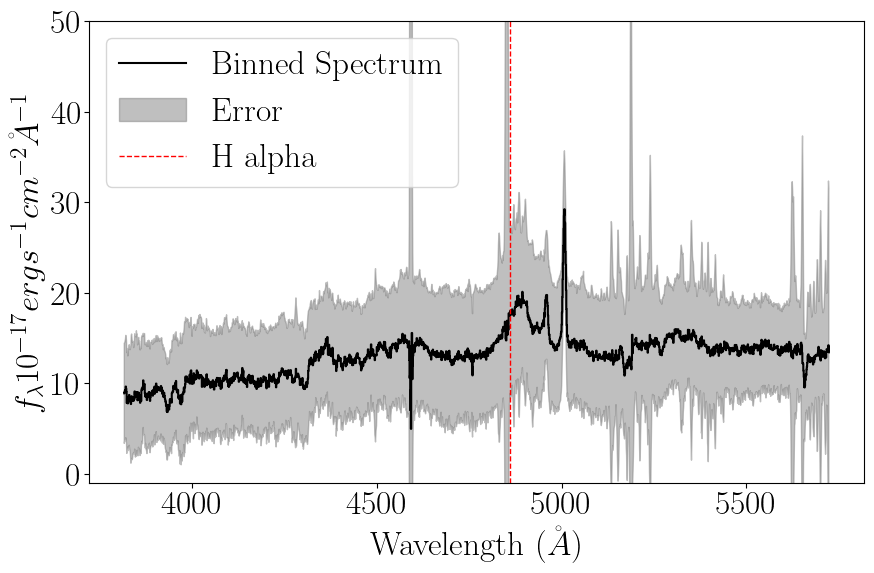

In [11]:
def read_spectrum(file_path, z):
    with fits.open(file_path) as hdul:
        data = hdul[0].data
    wl = data[0] / (1 + z)
    flux = data[1] * 1e17
    e_flux = data[2] * 1e17
    return wl, flux, e_flux

# File paths and redshift
file_path = 'HETspec/PSU22-2-010/spectrum_20220325_0000008_exp01_orange.fits'
z = 0.2144

# Read both spectra
wl, flux, e_flux = read_spectrum(file_path, z)


# Bin the combined data
bin_width = 1
bins = np.arange(min(wl), max(wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
indices = np.digitize(wl, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []

for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
        binned_flux_err.append(np.mean(e_flux[in_bin]))

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)


# Plotting the combined spectrum with the mask applied
plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=4861.333, color='r', linestyle='--', linewidth=1, label="H alpha")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.ylim(-1, 50)
plt.legend()
plt.show()


In [12]:
lam = binned_wl
flux_red = binned_flux
err = binned_flux_err

lam = np.nan_to_num(lam)
flux_red = np.nan_to_num(flux_red)
err = np.nan_to_num(err)


In [13]:
# deredden the spectrum
path_dust = '/home/serat/Downloads/sfddata-master'
ra = 147.6531250
dec = 51.4772500

m   = sfdmap.SFDMap(path_dust)
ebv = m.ebv(ra, dec)
Av  = 3.1*ebv
zero_flux  = np.where(flux_red == 0, True, False)
flux_red[zero_flux] = 1e-10
flux = extinction.remove(extinction.fitzpatrick99(lam.astype('double'),Av, 3.1),flux_red)
err_unred  = err*flux/flux_red
flux[zero_flux] = 0
err_unred[zero_flux] = 0

lam = lam

a = np.where(lam<5900)[0]
lam = lam[a]
flux = flux[a]
err = err[a]



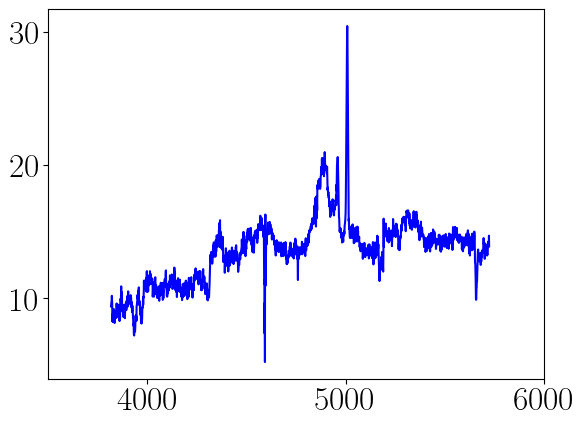

In [14]:
#plt.plot(lam, flux_red, 'r')
plt.plot(lam, flux, 'b')
plt.xlim(3500, 6000)
#plt.ylim(-100, 400)
plt.show()

## Set up emission lines

This sets emission lines and some offsets between them.

In [15]:
# set up the relevant emission lines
Hbeta = 4862.721
OIIIa = 4960.295
OIIIb = 5008.239
Hgamma = 4341.68
Hdelta = 4102.0
Hepsilon = 3971.
SII    = 4072.
NeIIIa = 3869.
NeIIIb = 3967.
OIIa   = 3726.
OIIb   = 3729.
NeVa   = 3346.
NeVb   = 3425.

OIIIa_off    = OIIIa/OIIIb
Hbeta_off    = Hbeta/OIIIb
SII_off      = SII/OIIIb
NeIIIa_off   = NeIIIa/OIIIb
NeIIIb_off   = NeIIIb/OIIIb
OIIa_off     = OIIa/OIIIb
OIIb_off     = OIIb/OIIIb
NeVa_off     = NeVa/OIIIb
NeVb_off     = NeVb/OIIIb
Hepsilon_off = Hepsilon/Hdelta

c = 2.99e5 # km/s

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [16]:
# starting guesses
broad_amp       = 100.
broad_sigma_kms = 11000.
broad_sigma     = (broad_sigma_kms/c)*Hbeta
narrow_sigma_kms = 800.
narrow_sigma     = (narrow_sigma_kms/c)*Hbeta
broad_fwhm = 3000.
narrow_fwhm = 800.

use = np.where((lam>4700) & (lam<5100))[0]


flux_unit = u.erg / (u.s * u.cm**2 * u.AA)
wavelength_unit = u.AA 
error_unit = flux_unit  

flux = flux
lam = lam
err_unred = err_unred

print(flux)



spec = pyspeckit.Spectrum(data=flux[use],xarr=lam[use], error=err_unred[use])
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'



[ 9.39332283  9.61297385  9.75197506 ... 13.98965936 14.695574
 13.88832075]


In [17]:
print(spec)

<Spectrum object named  over spectral range 4700.1 : 5099.3  and flux range = [11.4, 30.4] erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$ at 0x7042b55d8a9>


In [18]:
# get initial amplitudes
# H-beta
spec.specfit.selectregion(xmin = Hbeta - 5, xmax = Hbeta + 5)
ampHb = np.max(spec.data[spec.specfit.xmin:spec.specfit.xmax])

# [O III]
spec.specfit.selectregion(xmin = OIIIb - 10, xmax = OIIIb + 10)
ampOIIIb = np.max(spec.data[spec.specfit.xmin:spec.specfit.xmax]) 

spec.specfit.selectregion(xmin = 4750, xmax = 5200)

In [19]:
guesses = [ampOIIIb, OIIIb, narrow_sigma,\
           ampOIIIb, OIIIb, narrow_sigma,\
           0.33*ampOIIIb, OIIIa, narrow_sigma,\
           0.33*ampOIIIb, OIIIa, narrow_sigma,\
           ampHb, Hbeta, narrow_sigma,\
           ampHb, Hbeta, narrow_sigma,\
           ampHb, Hbeta, broad_sigma,\
           ampHb, Hbeta, broad_sigma,\
           ampHb, Hbeta, broad_sigma]
           
tied = ['','','',\
        '','','',\
        'p[0]/3','p[1] * {0}'.format(OIIIa_off),'p[2]',\
        'p[3]/3','p[4] * {0}'.format(OIIIa_off),'p[5]',\
        '','p[1] * {0}'.format(Hbeta_off),'p[2]',\
        'p[12]*p[3]/p[0]','p[4] * {0}'.format(Hbeta_off),'p[5]',\
        '','','',\
        '','','',\
        '','','']

fixed = [0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0]

In [20]:
print(Hbeta_off)

0.9709442780186808


In [21]:
spec.specfit.selectregion(xmin=4700,xmax=5100)
spec.specfit(fittype='gaussian',guesses=guesses,tied=tied,fixed=fixed,negamp=False,show_components=False,baseline=True)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,400 [pyspeckit.spectrum.interactive]


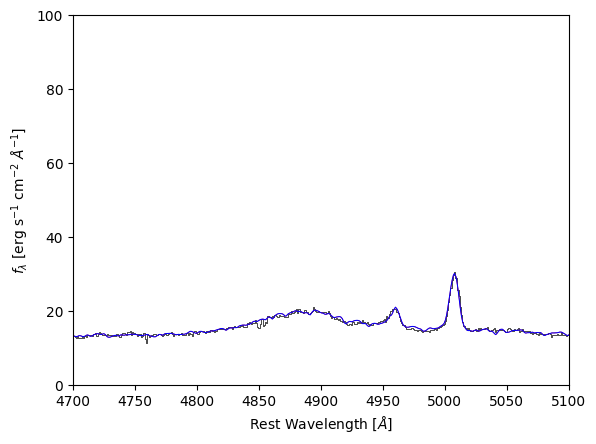

In [43]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=4700,xmax=5100,ymin=0,ymax=100,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

In [23]:
# check for any very small values (e.g., WIDTH8 was fitting to 1d-14 and then being used as an initial guess later)
spec.specfit.parinfo

[Param #0   AMPLITUDE0 =      15.0895 +/-         27.0078   Range:   [0,inf),
 Param #1       SHIFT0 =      5007.74 +/-         5.40918 ,
 Param #2       WIDTH0 =       3.4972 +/-         2.58696   Range:   [0,inf),
 Param #3   AMPLITUDE1 =      1.30094 +/-          14.623   Range:   [0,inf),
 Param #4       SHIFT1 =      5000.34 +/-         105.259 ,
 Param #5       WIDTH1 =        4.476 +/-         54.2757   Range:   [0,inf),
 Param #6   AMPLITUDE2 =      5.02984 +/-               0   Range:   [0,inf) Tied: p[0]/3,
 Param #7       SHIFT2 =       4959.8 +/-               0  Tied: p[1] * 0.9904269744315318,
 Param #8       WIDTH2 =       3.4972 +/-               0   Range:   [0,inf) Tied: p[2],
 Param #9   AMPLITUDE3 =     0.433645 +/-               0   Range:   [0,inf) Tied: p[3]/3,
 Param #10       SHIFT3 =      4952.47 +/-               0  Tied: p[4] * 0.9904269744315318,
 Param #11       WIDTH3 =        4.476 +/-               0   Range:   [0,inf) Tied: p[5],
 Param #12   AMPLITUDE

In [24]:
# save the best-fit values for the Gaussians in the H-beta region
o3l1amp   = spec.specfit.parinfo.AMPLITUDE0.value
o3l2amp   = spec.specfit.parinfo.AMPLITUDE1.value
o3l1cent  = spec.specfit.parinfo.SHIFT0.value
o3l2cent  = spec.specfit.parinfo.SHIFT1.value
o3l1width = (spec.specfit.parinfo.WIDTH0.value/o3l1cent)*2.99e5*2.35
o3l2width = (spec.specfit.parinfo.WIDTH1.value/o3l2cent)*2.99e5*2.35

o3s1amp   = spec.specfit.parinfo.AMPLITUDE2.value
o3s2amp   = spec.specfit.parinfo.AMPLITUDE3.value
o3s1cent  = spec.specfit.parinfo.SHIFT2.value
o3s2cent  = spec.specfit.parinfo.SHIFT3.value
o3s1width = (spec.specfit.parinfo.WIDTH2.value/o3s1cent)*2.99e5*2.35
o3s2width = (spec.specfit.parinfo.WIDTH3.value/o3s2cent)*2.99e5*2.35

hbn1amp   = spec.specfit.parinfo.AMPLITUDE4.value
hbn2amp   = spec.specfit.parinfo.AMPLITUDE5.value
hbn1cent  = spec.specfit.parinfo.SHIFT4.value
hbn2cent  = spec.specfit.parinfo.SHIFT5.value
hbn1width = (spec.specfit.parinfo.WIDTH4.value/hbn1cent)*2.99e5*2.35
hbn2width = (spec.specfit.parinfo.WIDTH5.value/hbn2cent)*2.99e5*2.35

hbb1amp   = spec.specfit.parinfo.AMPLITUDE8.value
hbb1cent  = spec.specfit.parinfo.SHIFT8.value
hbb1width = (spec.specfit.parinfo.WIDTH8.value/hbb1cent)*2.99e5*2.35

hbb2amp   = spec.specfit.parinfo.AMPLITUDE8.value
hbb2cent  = spec.specfit.parinfo.SHIFT8.value
hbb2width = (spec.specfit.parinfo.WIDTH8.value/hbb2cent)*2.99e5*2.35

hbb3amp   = spec.specfit.parinfo.AMPLITUDE7.value
hbb3cent  = spec.specfit.parinfo.SHIFT7.value
hbb3width = (spec.specfit.parinfo.WIDTH7.value/hbb3cent)*2.99e5*2.35

## Load templates

These are the Boroson & Green (1992) optical Fe II template, MILES stellar library, Balmer continuum, and High-order Balmer lines.

In [25]:
# load the templates
feii_template_path='/home/serat/Downloads/fe_op_templates.npy'
stellar_template_path='/home/serat/Downloads/PyQSOfit_MILES_templates.dat'
balmer_cont_template_path='/home/serat/Downloads/balmer_cont_templates.npy'
balmer_highorder_template_path='/home/serat/Downloads/balmer_highorder_templates.npy'

num_templates_feii=100
num_templates_host=8
num_templates_balmer_cont=20
num_templates_balmer_highorder=21

feii_templates=np.load(feii_template_path,allow_pickle=True)
stellar_templates=np.genfromtxt(stellar_template_path,skip_header=5)
balmer_cont_templates=np.load(balmer_cont_template_path,allow_pickle=True)
balmer_highorder_templates=np.load(balmer_highorder_template_path,allow_pickle=True)

## Fit the spectrum

Set up an initial guess and constrains and run the fit.

In [26]:
guesses = [40,0.5,\
          5.,20,0.,\
          2.,5,0.,\
          0.,19,0.,\
          0.5,2.,0.,\
          o3l1amp,o3l1cent,o3l1width,\
          o3l2amp,o3l2cent,o3l2width,\
          o3s1amp,o3s1cent,o3s1width,\
          o3s2amp,o3s2cent,o3s2width,\
          hbn1amp,hbn1cent,hbn1width,\
          hbn2amp,hbn2cent,hbn2width,\
          hbb1amp,hbb1cent,hbb1width,\
          hbb2amp,hbb2cent,hbb2width,\
          hbb3amp,hbb2cent,hbb3width,\
          3.,Hgamma,5000.,\
          3.,Hgamma,2000.,\
          2.,Hdelta,5000.,\
          2.,Hdelta,2000.,\
          0.1,Hepsilon,5000.,\
          0.1,Hepsilon,2000.,\
          0.,SII,o3l1width,\
          0.,SII,o3l2width,\
          1.,NeIIIa,o3s1width,\
          1.,NeIIIa,o3s2width,\
          1.,NeIIIb,o3l1width,\
          1.,NeIIIb,o3l2width,\
          1.,OIIa,o3s1width,\
          1.,OIIa,o3s2width,\
          1.,OIIb,o3l1width,\
          1.,OIIb,o3l2width,\
          0,NeVa,o3s1width,\
          0,NeVa,o3s2width,\
          0,NeVb,o3l1width,\
          0,NeVb,o3l2width]          

tied = ['','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        'p[14]/3','p[15] * {0}'.format(OIIIa_off),'p[16]',\
        'p[17]/3','p[18] * {0}'.format(OIIIa_off),'p[19]',\
        '','p[15] * {0}'.format(Hbeta_off),'p[16]',\
        'p[26]*p[17]/p[14]','p[18] * {0}'.format(Hbeta_off),'p[19]',\
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','p[48] * {0}'.format(Hepsilon_off),'p[49]', 
        'p[53]*p[50]/p[47]','p[51] * {0}'.format(Hepsilon_off),'p[52]', 
        '','p[15] * {0}'.format(SII_off),'p[16]',\
        'p[59]*p[17]/p[14]','p[18] * {0}'.format(SII_off),'p[19]',\
        'p[71]*3','p[15] * {0}'.format(NeIIIa_off),'p[16]',\
        'p[74]*3','p[18] * {0}'.format(NeIIIa_off),'p[19]',\
        '','p[15] * {0}'.format(NeIIIb_off),'p[16]',\
        'p[71]*p[17]/p[14]','p[18] * {0}'.format(NeIIIb_off),'p[19]',\
        'p[83]/3','p[15] * {0}'.format(OIIa_off),'p[16]',\
        'p[86]/3','p[18] * {0}'.format(OIIa_off),'p[19]',\
        '','p[15] * {0}'.format(OIIb_off),'p[16]',\
        'p[83]*p[17]/p[14]','p[18] * {0}'.format(OIIb_off),'p[19]',\
        'p[95]/3','p[15] * {0}'.format(NeVa_off),'p[16]',\
        'p[98]/3','p[18] * {0}'.format(NeVa_off),'p[19]',\
        '','p[15] * {0}'.format(NeVb_off),'p[16]',\
        'p[95]*p[17]/p[14]','p[18] * {0}'.format(NeVb_off),'p[19]']

fixed = [0,0,\
         0,0,0,\
         0,0,1,\
         1,1,1,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         1,1,1,\
         1,1,1,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         1,1,1,\
         1,1,1,\
         1,1,1,\
         1,1,1]

lmin = [True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True]

lmax = [True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True]

minp = [0,-5,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,4960,50,\
        0,4960,50,\
        0,4880,50,\
        0,4880,50,\
        0,4750,50,\
        0,4750,50,\
        0,4700,800,\
        0,4700,800,\
        0,4700,800,\
        0,Hgamma-50.,800.,\
        0,Hgamma-50.,800.,\
        0,Hdelta-50.,800.,\
        0,Hdelta-50.,800.,\
        0,Hepsilon-50.,800.,\
        0,Hepsilon-50.,800.,\
        0,SII-20.,50.,\
        0,SII-20.,50.,\
        0,NeIIIa-20.,50.,\
        0,NeIIIa-20.,50.,\
        0,NeIIIb-20.,50.,\
        0,NeIIIb-20.,50.,\
        0,OIIa-20.,50.,\
        0,OIIa-20.,50.,\
        0,OIIb-20.,50.,\
        0,OIIb-20.,50.,\
        0,NeVa-20.,50.,\
        0,NeVa-20.,50.,\
        0,NeVb-20.,50.,\
        0,NeVb-20.,50.]

maxp = [1e6,5,\
        1e6,99,0.05,\
        1e6,7,0.05,\
        1e6,19,0.05,\
        1e6,20,0.0,\
        1e6,5100,2500.,\
        1e6,5100,2500.,\
        1e6,5000,2500,\
        1e6,5000,2500,\
        1e6,5100,2500,\
        1e6,5100,2500,\
        1e6,5100,100000,\
        1e6,5100,100000,\
        1e6,5100,100000,\
        1e6,Hgamma+50,100000,\
        1e6,Hgamma+50,100000,\
        1e6,Hdelta+50,100000,\
        1e6,Hdelta+50,100000,\
        1e6,Hepsilon+50,100000.,
        1e6,Hepsilon+50,100000.,
        1e6,SII+20.,2500.,\
        1e6,SII+20.,2500.,\
        1e6,NeIIIa+20.,2500.,\
        1e6,NeIIIa+20.,2500.,\
        1e6,NeIIIb+20.,2500.,\
        1e6,NeIIIb+20.,2500.,\
        1e6,OIIa+20.,2500.,\
        1e6,OIIa+20.,2500.,\
        1e6,OIIb+20.,2500.,\
        1e6,OIIb+20.,2500.,\
        1e6,NeVa+20.,2500.,\
        1e6,NeVa+20.,2500.,\
        1e6,NeVb+20.,2500.,\
        1e6,NeVb+20.,2500.]

step =[5,0.05,\
       0.5,0.25,0.005,\
       0.5,0.25,0.005,\
       0.5,0.5,0.005,\
       0.05,0.25,0.005,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,50,\
       0.5,0.1,50,\
       0.5,0.1,50,\
       0.5,0.1,10,\
       0.5,0.1,10,\
       0.5,0.1,10,\
       0.5,0.1,10,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5] 

In [27]:
print(guesses)

[40, 0.5, 5.0, 20, 0.0, 2.0, 5, 0.0, 0.0, 19, 0.0, 0.5, 2.0, 0.0, 15.089524479917396, 5007.743665881382, 490.70156838899777, 1.3009355887858898, 5000.337936264791, 628.9702447046485, 5.029841493305798, 4959.804407727565, 495.4444709774208, 0.43364519626196324, 4952.469573349947, 635.0495906734103, 0.03777656436363163, 4862.24005817182, 505.38592120891695, 0.003256887058841115, 4855.049507376038, 647.7923182040188, 8.117859541940932, 4884.97501965239, 6652.897257576512, 8.117859541940932, 4884.97501965239, 6652.897257576512, 14.568178302609377, 4884.97501965239, 17666.50915178443, 3.0, 4341.68, 5000.0, 3.0, 4341.68, 2000.0, 2.0, 4102.0, 5000.0, 2.0, 4102.0, 2000.0, 0.1, 3971.0, 5000.0, 0.1, 3971.0, 2000.0, 0.0, 4072.0, 490.70156838899777, 0.0, 4072.0, 628.9702447046485, 1.0, 3869.0, 495.4444709774208, 1.0, 3869.0, 635.0495906734103, 1.0, 3967.0, 490.70156838899777, 1.0, 3967.0, 628.9702447046485, 1.0, 3726.0, 495.4444709774208, 1.0, 3726.0, 635.0495906734103, 1.0, 3729.0, 490.7015683889

In [28]:
# check for guess limit combinations that are bad
# if any are found, go back up to the initial fit and
# adjust guess parameters to avoid the issue
for i,par,pmin,pmax in zip(np.arange(101),guesses,minp,maxp):
    if (par<pmin) | (par>pmax):
        print("Parameter number {0:} with value {1:} is not in range {2:}-{3:}.".format(i,par,pmin,pmax))

In [29]:
print(np.max(lam))



5722.990777338604


In [30]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux, xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('optagn',optical_agn_fitter(),101)
spec.specfit.selectregion(xmin=3715,xmax=5600)
spec.specfit(fittype='optagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,limitedmin=lmin,limitedmax=lmax,minpars=minp,maxpars=maxp,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1784 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  8606.055999  DOF =  1743
   PL_S0 = 40  
   PL_E0 = 0.5  
   FE_S0 = 5  
   FE_INDEX0 = 20  
   FE_SHIFT0 = 0  
   SB_S0 = 2  
   SB_INDEX0 = 5  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.5  
   BH_INDEX0 = 2  
   BH_SHIFT0 = 0  
   O3L1_F0 = 15.08952448  
   O3L1_CENT0 = 5007.743666  
   O3L1_FWHM0 = 490.7015684  
   O3L2_F0 = 1.300935589  
   O3L2_CENT0 = 5000.337936  
   O3L2_FWHM0 = 628.9702447  
   O3S1_F0 = 5.029841493  
   O3S1_CENT0 = 4959.804408  
   O3S1_FWHM0 = 490.7015684  
   O3S2_F0 = 0.4336451963  
   O3S2_CENT0 = 4952.469573  
   O3S2_FWHM0 = 628.9702447  
   HBN1_F0 = 0.03777656436  
   HBN1_CENT0 = 4862.240058  
   HBN1_FWHM0 = 490.7015684  
   HBN2_F0 = 0.003256887059  
   HBN2_CENT0 = 4855.049507  
   HBN2_FWHM0 = 628.9702447  
   HHB1_F0 = 8.117859542  
   HBB1_CENT0 = 4884.97502  
   HBB1_FWHM0 

Iter       7    CHI-SQUARE =  8.939440724e-13  DOF =  2516
   PL_S0 = 22.42769486  
   PL_E0 = 0.1193179878  
   FE_S0 = 1.732343928  
   FE_INDEX0 = 16.94310316  
   FE_SHIFT0 = 0.002400865813  
   SB_S0 = 9.386112599  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.4847187027  
   BH_INDEX0 = 3.544778132  
   BH_SHIFT0 = 0  
   O3L1_F0 = 52.20654837  
   O3L1_CENT0 = 5007.298265  
   O3L1_FWHM0 = 459.1183052  
   O3L2_F0 = 18.92082968  
   O3L2_CENT0 = 5004.591813  
   O3L2_FWHM0 = 984.3043941  
   O3S1_F0 = 17.40218279  
   O3S1_CENT0 = 4959.363271  
   O3S1_FWHM0 = 459.1183052  
   O3S2_F0 = 6.306943228  
   O3S2_CENT0 = 4956.682728  
   O3S2_FWHM0 = 984.3043941  
   HBN1_F0 = 4.771496312  
   HBN1_CENT0 = 4861.807599  
   HBN1_FWHM0 = 459.1183052  
   HBN2_F0 = 1.729297797  
   HBN2_CENT0 = 4859.179785  
   HBN2_FWHM0 = 984.3043941  
   HHB1_F0 = 5.955179193  
   HBB1_CENT0 = 4869.418539  
   HBB1_FWHM0 = 8544.315931  
   H

Iter      10    CHI-SQUARE =  7.261404164e-13  DOF =  2516
   PL_S0 = 21.72579271  
   PL_E0 = 0.1100762151  
   FE_S0 = 0  
   FE_INDEX0 = 16.96031433  
   FE_SHIFT0 = 0.002298363781  
   SB_S0 = 11.46896708  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.3672082325  
   BH_INDEX0 = 3.62011461  
   BH_SHIFT0 = 0  
   O3L1_F0 = 52.38104851  
   O3L1_CENT0 = 5007.28461  
   O3L1_FWHM0 = 464.2059512  
   O3L2_F0 = 19.77757198  
   O3L2_CENT0 = 5004.627792  
   O3L2_FWHM0 = 985.773286  
   O3S1_F0 = 17.4603495  
   O3S1_CENT0 = 4959.349747  
   O3S1_FWHM0 = 464.2059512  
   O3S2_F0 = 6.592523993  
   O3S2_CENT0 = 4956.718362  
   O3S2_FWHM0 = 985.773286  
   HBN1_F0 = 4.730912115  
   HBN1_CENT0 = 4861.794341  
   HBN1_FWHM0 = 464.2059512  
   HBN2_F0 = 1.786255861  
   HBN2_CENT0 = 4859.214718  
   HBN2_FWHM0 = 985.773286  
   HHB1_F0 = 6.453088286  
   HBB1_CENT0 = 4869.432161  
   HBB1_FWHM0 = 8568.880707  
   HHB2_F0 = 5.07719

Iter      13    CHI-SQUARE =  6.44029229e-13  DOF =  2516
   PL_S0 = 20.80423605  
   PL_E0 = 0.1117280752  
   FE_S0 = 0  
   FE_INDEX0 = 16.9792915  
   FE_SHIFT0 = 0.002323642417  
   SB_S0 = 13.06851727  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.2724758479  
   BH_INDEX0 = 3.663098221  
   BH_SHIFT0 = 0  
   O3L1_F0 = 52.4520042  
   O3L1_CENT0 = 5007.27091  
   O3L1_FWHM0 = 468.3132292  
   O3L2_F0 = 20.47731223  
   O3L2_CENT0 = 5004.658198  
   O3L2_FWHM0 = 986.8311259  
   O3S1_F0 = 17.4840014  
   O3S1_CENT0 = 4959.336178  
   O3S1_FWHM0 = 468.3132292  
   O3S2_F0 = 6.825770742  
   O3S2_CENT0 = 4956.748477  
   O3S2_FWHM0 = 986.8311259  
   HBN1_F0 = 4.64260719  
   HBN1_CENT0 = 4861.781039  
   HBN1_FWHM0 = 468.3132292  
   HBN2_F0 = 1.812478254  
   HBN2_CENT0 = 4859.24424  
   HBN2_FWHM0 = 986.8311259  
   HHB1_F0 = 6.52774489  
   HBB1_CENT0 = 4869.439723  
   HBB1_FWHM0 = 8587.640645  
   HHB2_F0 = 5.0248729

Iter      16    CHI-SQUARE =  4.380549842e-13  DOF =  2516
   PL_S0 = 16.10651544  
   PL_E0 = 0.0970991196  
   FE_S0 = 0  
   FE_INDEX0 = 17.52460997  
   FE_SHIFT0 = 0.003050036498  
   SB_S0 = 19.83780717  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.5426341651  
   BH_INDEX0 = 4.222780545  
   BH_SHIFT0 = 0  
   O3L1_F0 = 49.17456441  
   O3L1_CENT0 = 5007.290446  
   O3L1_FWHM0 = 479.084602  
   O3L2_F0 = 24.77555065  
   O3L2_CENT0 = 5005.360531  
   O3L2_FWHM0 = 996.0464667  
   O3S1_F0 = 16.39152147  
   O3S1_CENT0 = 4959.355527  
   O3S1_FWHM0 = 479.084602  
   O3S2_F0 = 8.258516882  
   O3S2_CENT0 = 4957.444086  
   O3S2_FWHM0 = 996.0464667  
   HBN1_F0 = 5.33820899  
   HBN1_CENT0 = 4861.800007  
   HBN1_FWHM0 = 479.084602  
   HBN2_F0 = 2.689542221  
   HBN2_CENT0 = 4859.926167  
   HBN2_FWHM0 = 996.0464667  
   HHB1_F0 = 5.225591288  
   HBB1_CENT0 = 4869.656591  
   HBB1_FWHM0 = 8763.655686  
   HHB2_F0 = 3.101

Iter      19    CHI-SQUARE =  4.106588613e-13  DOF =  2516
   PL_S0 = 15.00711303  
   PL_E0 = 0.09108719474  
   FE_S0 = 0  
   FE_INDEX0 = 18.01173287  
   FE_SHIFT0 = 0.003698910906  
   SB_S0 = 21.02219216  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.7371218134  
   BH_INDEX0 = 4.781942218  
   BH_SHIFT0 = 0  
   O3L1_F0 = 48.20701097  
   O3L1_CENT0 = 5007.307141  
   O3L1_FWHM0 = 486.9232408  
   O3L2_F0 = 26.44900394  
   O3L2_CENT0 = 5005.697234  
   O3L2_FWHM0 = 1003.370763  
   O3S1_F0 = 16.06900366  
   O3S1_CENT0 = 4959.372062  
   O3S1_FWHM0 = 486.9232408  
   O3S2_F0 = 8.816334647  
   O3S2_CENT0 = 4957.777567  
   O3S2_FWHM0 = 1003.370763  
   HBN1_F0 = 5.976911527  
   HBN1_CENT0 = 4861.816217  
   HBN1_FWHM0 = 486.9232408  
   HBN2_F0 = 3.279260699  
   HBN2_CENT0 = 4860.253087  
   HBN2_FWHM0 = 1003.370763  
   HHB1_F0 = 5.03643531  
   HBB1_CENT0 = 4869.848343  
   HBB1_FWHM0 = 8876.824736  
   HHB2_F0 = 2

Iter      22    CHI-SQUARE =  4.021239926e-13  DOF =  2516
   PL_S0 = 14.70029821  
   PL_E0 = 0.09318333441  
   FE_S0 = 0  
   FE_INDEX0 = 18.25875308  
   FE_SHIFT0 = 0.004027955371  
   SB_S0 = 21.24945572  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.8178401386  
   BH_INDEX0 = 5.059916126  
   BH_SHIFT0 = 0  
   O3L1_F0 = 47.93820507  
   O3L1_CENT0 = 5007.314403  
   O3L1_FWHM0 = 491.845274  
   O3L2_F0 = 27.06072685  
   O3L2_CENT0 = 5005.803992  
   O3L2_FWHM0 = 1007.857079  
   O3S1_F0 = 15.97940169  
   O3S1_CENT0 = 4959.379254  
   O3S1_FWHM0 = 491.845274  
   O3S2_F0 = 9.020242283  
   O3S2_CENT0 = 4957.883302  
   O3S2_FWHM0 = 1007.857079  
   HBN1_F0 = 6.246834398  
   HBN1_CENT0 = 4861.823267  
   HBN1_FWHM0 = 491.845274  
   HBN2_F0 = 3.526287208  
   HBN2_CENT0 = 4860.356743  
   HBN2_FWHM0 = 1007.857079  
   HHB1_F0 = 4.942708696  
   HBB1_CENT0 = 4869.945871  
   HBB1_FWHM0 = 8927.657443  
   HHB2_F0 = 2.6

Iter      25    CHI-SQUARE =  3.954461816e-13  DOF =  2516
   PL_S0 = 14.51833828  
   PL_E0 = 0.09237852927  
   FE_S0 = 0  
   FE_INDEX0 = 18.42502425  
   FE_SHIFT0 = 0.00424943768  
   SB_S0 = 21.46015388  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.8864546291  
   BH_INDEX0 = 5.266741335  
   BH_SHIFT0 = 0  
   O3L1_F0 = 47.42251512  
   O3L1_CENT0 = 5007.287759  
   O3L1_FWHM0 = 494.9775358  
   O3L2_F0 = 27.4859379  
   O3L2_CENT0 = 5005.876279  
   O3L2_FWHM0 = 1010.651834  
   O3S1_F0 = 15.80750504  
   O3S1_CENT0 = 4959.352865  
   O3S1_FWHM0 = 494.9775358  
   O3S2_F0 = 9.161979301  
   O3S2_CENT0 = 4957.954897  
   O3S2_FWHM0 = 1010.651834  
   HBN1_F0 = 6.356326238  
   HBN1_CENT0 = 4861.797398  
   HBN1_FWHM0 = 494.9775358  
   HBN2_F0 = 3.684106332  
   HBN2_CENT0 = 4860.42693  
   HBN2_FWHM0 = 1010.651834  
   HHB1_F0 = 4.820716214  
   HBB1_CENT0 = 4870.011104  
   HBB1_FWHM0 = 8962.377825  
   HHB2_F0 = 2.4

Iter      28    CHI-SQUARE =  3.928192942e-13  DOF =  2516
   PL_S0 = 14.45807218  
   PL_E0 = 0.09177314652  
   FE_S0 = 0  
   FE_INDEX0 = 18.4621038  
   FE_SHIFT0 = 0.004298829667  
   SB_S0 = 21.53008929  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.907287311  
   BH_INDEX0 = 5.319981369  
   BH_SHIFT0 = 0  
   O3L1_F0 = 47.16564966  
   O3L1_CENT0 = 5007.269428  
   O3L1_FWHM0 = 495.5691414  
   O3L2_F0 = 27.58931109  
   O3L2_CENT0 = 5005.893215  
   O3L2_FWHM0 = 1011.164975  
   O3S1_F0 = 15.72188322  
   O3S1_CENT0 = 4959.33471  
   O3S1_FWHM0 = 495.5691414  
   O3S2_F0 = 9.196437032  
   O3S2_CENT0 = 4957.971671  
   O3S2_FWHM0 = 1011.164975  
   HBN1_F0 = 6.348784878  
   HBN1_CENT0 = 4861.7796  
   HBN1_FWHM0 = 495.5691414  
   HBN2_F0 = 3.713689991  
   HBN2_CENT0 = 4860.443373  
   HBN2_FWHM0 = 1011.164975  
   HHB1_F0 = 4.758415437  
   HBB1_CENT0 = 4870.025476  
   HBB1_FWHM0 = 8970.355775  
   HHB2_F0 = 2.416

Iter      31    CHI-SQUARE =  3.864355195e-13  DOF =  2516
   PL_S0 = 14.25168984  
   PL_E0 = 0.09059898696  
   FE_S0 = 0  
   FE_INDEX0 = 18.613605  
   FE_SHIFT0 = 0.004500637579  
   SB_S0 = 21.74130821  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 0.9767484877  
   BH_INDEX0 = 5.517411292  
   BH_SHIFT0 = 0  
   O3L1_F0 = 46.45216033  
   O3L1_CENT0 = 5007.238268  
   O3L1_FWHM0 = 497.916471  
   O3L2_F0 = 27.97458777  
   O3L2_CENT0 = 5005.962131  
   O3L2_FWHM0 = 1013.403704  
   O3S1_F0 = 15.48405344  
   O3S1_CENT0 = 4959.303848  
   O3S1_FWHM0 = 497.916471  
   O3S2_F0 = 9.324862592  
   O3S2_CENT0 = 4958.039928  
   O3S2_FWHM0 = 1013.403704  
   HBN1_F0 = 6.414965606  
   HBN1_CENT0 = 4861.749345  
   HBN1_FWHM0 = 497.916471  
   HBN2_F0 = 3.863243757  
   HBN2_CENT0 = 4860.510287  
   HBN2_FWHM0 = 1013.403704  
   HHB1_F0 = 4.717594883  
   HBB1_CENT0 = 4870.084615  
   HBB1_FWHM0 = 9002.347723  
   HHB2_F0 = 2.354

Iter      34    CHI-SQUARE =  3.788729508e-13  DOF =  2516
   PL_S0 = 13.99933532  
   PL_E0 = 0.08960274723  
   FE_S0 = 0  
   FE_INDEX0 = 18.85160596  
   FE_SHIFT0 = 0.0048176679  
   SB_S0 = 21.99339577  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.06834028  
   BH_INDEX0 = 5.796952067  
   BH_SHIFT0 = 0  
   O3L1_F0 = 45.65170671  
   O3L1_CENT0 = 5007.222189  
   O3L1_FWHM0 = 500.927958  
   O3L2_F0 = 28.46662414  
   O3L2_CENT0 = 5006.063852  
   O3L2_FWHM0 = 1016.844198  
   O3S1_F0 = 15.21723557  
   O3S1_CENT0 = 4959.287923  
   O3S1_FWHM0 = 500.927958  
   O3S2_F0 = 9.488874712  
   O3S2_CENT0 = 4958.140675  
   O3S2_FWHM0 = 1016.844198  
   HBN1_F0 = 6.535645999  
   HBN1_CENT0 = 4861.733733  
   HBN1_FWHM0 = 500.927958  
   HBN2_F0 = 4.07537399  
   HBN2_CENT0 = 4860.609053  
   HBN2_FWHM0 = 1016.844198  
   HHB1_F0 = 4.679112447  
   HBB1_CENT0 = 4870.17788  
   HBB1_FWHM0 = 9051.427024  
   HHB2_F0 = 2.2964002

Iter      37    CHI-SQUARE =  3.78055708e-13  DOF =  2516
   PL_S0 = 13.98939337  
   PL_E0 = 0.08954642495  
   FE_S0 = 0  
   FE_INDEX0 = 18.86345872  
   FE_SHIFT0 = 0.004833456427  
   SB_S0 = 22.00457905  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.072585104  
   BH_INDEX0 = 5.81013008  
   BH_SHIFT0 = 0  
   O3L1_F0 = 45.61701896  
   O3L1_CENT0 = 5007.221715  
   O3L1_FWHM0 = 501.0600964  
   O3L2_F0 = 28.48830713  
   O3L2_CENT0 = 5006.068655  
   O3L2_FWHM0 = 1017.011025  
   O3S1_F0 = 15.20567299  
   O3S1_CENT0 = 4959.287453  
   O3S1_FWHM0 = 501.0600964  
   O3S2_F0 = 9.496102378  
   O3S2_CENT0 = 4958.145432  
   O3S2_FWHM0 = 1017.011025  
   HBN1_F0 = 6.540895453  
   HBN1_CENT0 = 4861.733273  
   HBN1_FWHM0 = 501.0600964  
   HBN2_F0 = 4.084857863  
   HBN2_CENT0 = 4860.613716  
   HBN2_FWHM0 = 1017.011025  
   HHB1_F0 = 4.675942107  
   HBB1_CENT0 = 4870.18253  
   HBB1_FWHM0 = 9053.843305  
   HHB2_F0 = 2.29

Iter      40    CHI-SQUARE =  3.779441134e-13  DOF =  2516
   PL_S0 = 13.98930475  
   PL_E0 = 0.08945682425  
   FE_S0 = 0  
   FE_INDEX0 = 18.86348464  
   FE_SHIFT0 = 0.004833490952  
   SB_S0 = 22.00746458  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.073256898  
   BH_INDEX0 = 5.810829052  
   BH_SHIFT0 = 0  
   O3L1_F0 = 45.59963257  
   O3L1_CENT0 = 5007.220245  
   O3L1_FWHM0 = 501.0391401  
   O3L2_F0 = 28.48878829  
   O3L2_CENT0 = 5006.068698  
   O3L2_FWHM0 = 1016.99405  
   O3S1_F0 = 15.19987752  
   O3S1_CENT0 = 4959.285998  
   O3S1_FWHM0 = 501.0391401  
   O3S2_F0 = 9.496262763  
   O3S2_CENT0 = 4958.145475  
   O3S2_FWHM0 = 1016.99405  
   HBN1_F0 = 6.535879009  
   HBN1_CENT0 = 4861.731846  
   HBN1_FWHM0 = 501.0391401  
   HBN2_F0 = 4.0833503  
   HBN2_CENT0 = 4860.613758  
   HBN2_FWHM0 = 1016.99405  
   HHB1_F0 = 4.669156799  
   HBB1_CENT0 = 4870.182519  
   HBB1_FWHM0 = 9053.866958  
   HHB2_F0 = 2.2856

Iter      43    CHI-SQUARE =  3.771135618e-13  DOF =  2516
   PL_S0 = 13.97863675  
   PL_E0 = 0.08893136358  
   FE_S0 = 0  
   FE_INDEX0 = 18.86517938  
   FE_SHIFT0 = 0.004835748436  
   SB_S0 = 22.02799833  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.078783455  
   BH_INDEX0 = 5.817954366  
   BH_SHIFT0 = 0  
   O3L1_F0 = 45.46344443  
   O3L1_CENT0 = 5007.209353  
   O3L1_FWHM0 = 500.9030161  
   O3L2_F0 = 28.49666924  
   O3L2_CENT0 = 5006.069752  
   O3L2_FWHM0 = 1016.887072  
   O3S1_F0 = 15.15448148  
   O3S1_CENT0 = 4959.27521  
   O3S1_FWHM0 = 500.9030161  
   O3S2_F0 = 9.498889746  
   O3S2_CENT0 = 4958.146518  
   O3S2_FWHM0 = 1016.887072  
   HBN1_F0 = 6.501226878  
   HBN1_CENT0 = 4861.72127  
   HBN1_FWHM0 = 500.9030161  
   HBN2_F0 = 4.074995071  
   HBN2_CENT0 = 4860.614781  
   HBN2_FWHM0 = 1016.887072  
   HHB1_F0 = 4.625978997  
   HBB1_CENT0 = 4870.183021  
   HBB1_FWHM0 = 9054.366171  
   HHB2_F0 = 2.2

Iter      46    CHI-SQUARE =  3.719930483e-13  DOF =  2516
   PL_S0 = 13.8239014  
   PL_E0 = 0.08707288818  
   FE_S0 = 0  
   FE_INDEX0 = 18.96371824  
   FE_SHIFT0 = 0.0049670076  
   SB_S0 = 22.17874583  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.132451797  
   BH_INDEX0 = 5.949925477  
   BH_SHIFT0 = 0  
   O3L1_F0 = 44.66886425  
   O3L1_CENT0 = 5007.172945  
   O3L1_FWHM0 = 501.5036528  
   O3L2_F0 = 28.73414313  
   O3L2_CENT0 = 5006.114215  
   O3L2_FWHM0 = 1017.751255  
   O3S1_F0 = 14.88962142  
   O3S1_CENT0 = 4959.23915  
   O3S1_FWHM0 = 501.5036528  
   O3S2_F0 = 9.578047711  
   O3S2_CENT0 = 4958.190555  
   O3S2_FWHM0 = 1017.751255  
   HBN1_F0 = 6.45046237  
   HBN1_CENT0 = 4861.68592  
   HBN1_FWHM0 = 501.5036528  
   HBN2_F0 = 4.149389337  
   HBN2_CENT0 = 4860.657952  
   HBN2_FWHM0 = 1017.751255  
   HHB1_F0 = 4.573429854  
   HBB1_CENT0 = 4870.221068  
   HBB1_FWHM0 = 9075.286464  
   HHB2_F0 = 2.17205

Iter      49    CHI-SQUARE =  3.652688044e-13  DOF =  2516
   PL_S0 = 13.59046266  
   PL_E0 = 0.08593637749  
   FE_S0 = 0  
   FE_INDEX0 = 19.21580051  
   FE_SHIFT0 = 0.005302795004  
   SB_S0 = 22.40006678  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.22099063  
   BH_INDEX0 = 6.217368517  
   BH_SHIFT0 = 0  
   O3L1_F0 = 43.85889236  
   O3L1_CENT0 = 5007.169508  
   O3L1_FWHM0 = 503.8160499  
   O3L2_F0 = 29.21114658  
   O3L2_CENT0 = 5006.216547  
   O3L2_FWHM0 = 1020.921448  
   O3S1_F0 = 14.61963079  
   O3S1_CENT0 = 4959.235747  
   O3S1_FWHM0 = 503.8160499  
   O3S2_F0 = 9.737048859  
   O3S2_CENT0 = 4958.291908  
   O3S2_FWHM0 = 1020.921448  
   HBN1_F0 = 6.545206335  
   HBN1_CENT0 = 4861.682583  
   HBN1_FWHM0 = 503.8160499  
   HBN2_F0 = 4.359275197  
   HBN2_CENT0 = 4860.757311  
   HBN2_FWHM0 = 1020.921448  
   HHB1_F0 = 4.569633287  
   HBB1_CENT0 = 4870.319884  
   HBB1_FWHM0 = 9126.653108  
   HHB2_F0 = 2.

Iter      52    CHI-SQUARE =  3.585089045e-13  DOF =  2516
   PL_S0 = 13.3642824  
   PL_E0 = 0.0841889895  
   FE_S0 = 0  
   FE_INDEX0 = 19.46888072  
   FE_SHIFT0 = 0.005639911712  
   SB_S0 = 22.62054243  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.308229737  
   BH_INDEX0 = 6.475475403  
   BH_SHIFT0 = 0  
   O3L1_F0 = 42.93686278  
   O3L1_CENT0 = 5007.152921  
   O3L1_FWHM0 = 505.2250303  
   O3L2_F0 = 29.63596443  
   O3L2_CENT0 = 5006.311914  
   O3L2_FWHM0 = 1023.568403  
   O3S1_F0 = 14.31228759  
   O3S1_CENT0 = 4959.219318  
   O3S1_FWHM0 = 505.2250303  
   O3S2_F0 = 9.878654812  
   O3S2_CENT0 = 4958.386362  
   O3S2_FWHM0 = 1023.568403  
   HBN1_F0 = 6.563016518  
   HBN1_CENT0 = 4861.666478  
   HBN1_FWHM0 = 505.2250303  
   HBN2_F0 = 4.529937949  
   HBN2_CENT0 = 4860.849907  
   HBN2_FWHM0 = 1023.568403  
   HHB1_F0 = 4.513363164  
   HBB1_CENT0 = 4870.418916  
   HBB1_FWHM0 = 9177.958659  
   HHB2_F0 = 2.0

Iter      55    CHI-SQUARE =  3.518636005e-13  DOF =  2516
   PL_S0 = 13.13486504  
   PL_E0 = 0.08187409584  
   FE_S0 = 0  
   FE_INDEX0 = 19.71402425  
   FE_SHIFT0 = 0.005966456339  
   SB_S0 = 22.8370553  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.391271112  
   BH_INDEX0 = 6.712527826  
   BH_SHIFT0 = 0  
   O3L1_F0 = 41.89978703  
   O3L1_CENT0 = 5007.125006  
   O3L1_FWHM0 = 505.5785311  
   O3L2_F0 = 30.01739444  
   O3L2_CENT0 = 5006.397428  
   O3L2_FWHM0 = 1025.439882  
   O3S1_F0 = 13.96659568  
   O3S1_CENT0 = 4959.19167  
   O3S1_FWHM0 = 505.5785311  
   O3S2_F0 = 10.00579815  
   O3S2_CENT0 = 4958.471058  
   O3S2_FWHM0 = 1025.439882  
   HBN1_F0 = 6.511061429  
   HBN1_CENT0 = 4861.639374  
   HBN1_FWHM0 = 505.5785311  
   HBN2_F0 = 4.664584549  
   HBN2_CENT0 = 4860.932936  
   HBN2_FWHM0 = 1025.439882  
   HHB1_F0 = 4.454789358  
   HBB1_CENT0 = 4870.514623  
   HBB1_FWHM0 = 9227.564789  
   HHB2_F0 = 2.0

Iter      58    CHI-SQUARE =  3.454693643e-13  DOF =  2516
   PL_S0 = 12.90502306  
   PL_E0 = 0.07896856584  
   FE_S0 = 0  
   FE_INDEX0 = 19.95351888  
   FE_SHIFT0 = 0.006285476303  
   SB_S0 = 23.04780301  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.469253422  
   BH_INDEX0 = 6.925218824  
   BH_SHIFT0 = 0  
   O3L1_F0 = 40.78953947  
   O3L1_CENT0 = 5007.091946  
   O3L1_FWHM0 = 504.9299667  
   O3L2_F0 = 30.37929249  
   O3L2_CENT0 = 5006.474338  
   O3L2_FWHM0 = 1026.501512  
   O3S1_F0 = 13.59651316  
   O3S1_CENT0 = 4959.158926  
   O3S1_FWHM0 = 504.9299667  
   O3S2_F0 = 10.12643083  
   O3S2_CENT0 = 4958.547232  
   O3S2_FWHM0 = 1026.501512  
   HBN1_F0 = 6.408160912  
   HBN1_CENT0 = 4861.607274  
   HBN1_FWHM0 = 504.9299667  
   HBN2_F0 = 4.772679398  
   HBN2_CENT0 = 4861.007612  
   HBN2_FWHM0 = 1026.501512  
   HHB1_F0 = 4.403032225  
   HBB1_CENT0 = 4870.607951  
   HBB1_FWHM0 = 9275.94001  
   HHB2_F0 = 1.

Iter      61    CHI-SQUARE =  3.394748829e-13  DOF =  2516
   PL_S0 = 12.67282516  
   PL_E0 = 0.07549872095  
   FE_S0 = 0  
   FE_INDEX0 = 20.1855623  
   FE_SHIFT0 = 0.006594570858  
   SB_S0 = 23.24906764  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.540556689  
   BH_INDEX0 = 7.112847162  
   BH_SHIFT0 = 0  
   O3L1_F0 = 39.64596634  
   O3L1_CENT0 = 5007.058313  
   O3L1_FWHM0 = 503.2721948  
   O3L2_F0 = 30.73678027  
   O3L2_CENT0 = 5006.542546  
   O3L2_FWHM0 = 1026.632963  
   O3S1_F0 = 13.21532211  
   O3S1_CENT0 = 4959.125615  
   O3S1_FWHM0 = 503.2721948  
   O3S2_F0 = 10.24559342  
   O3S2_CENT0 = 4958.614786  
   O3S2_FWHM0 = 1026.632963  
   HBN1_F0 = 6.269942757  
   HBN1_CENT0 = 4861.574618  
   HBN1_FWHM0 = 503.2721948  
   HBN2_F0 = 4.860969996  
   HBN2_CENT0 = 4861.073837  
   HBN2_FWHM0 = 1026.632963  
   HHB1_F0 = 4.364722425  
   HBB1_CENT0 = 4870.698224  
   HBB1_FWHM0 = 9322.765265  
   HHB2_F0 = 1.

Iter      64    CHI-SQUARE =  3.336140566e-13  DOF =  2516
   PL_S0 = 12.41716318  
   PL_E0 = 0.07103228476  
   FE_S0 = 0  
   FE_INDEX0 = 20.41445716  
   FE_SHIFT0 = 0.006899471363  
   SB_S0 = 23.45357622  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.607541637  
   BH_INDEX0 = 7.27297005  
   BH_SHIFT0 = 0  
   O3L1_F0 = 38.40460744  
   O3L1_CENT0 = 5007.021464  
   O3L1_FWHM0 = 500.1599861  
   O3L2_F0 = 31.1124973  
   O3L2_CENT0 = 5006.602149  
   O3L2_FWHM0 = 1025.377666  
   O3S1_F0 = 12.80153581  
   O3S1_CENT0 = 4959.08912  
   O3S1_FWHM0 = 500.1599861  
   O3S2_F0 = 10.37083243  
   O3S2_CENT0 = 4958.673819  
   O3S2_FWHM0 = 1025.377666  
   HBN1_F0 = 6.082563815  
   HBN1_CENT0 = 4861.538841  
   HBN1_FWHM0 = 500.1599861  
   HBN2_F0 = 4.92763142  
   HBN2_CENT0 = 4861.131709  
   HBN2_FWHM0 = 1025.377666  
   HHB1_F0 = 4.334923285  
   HBB1_CENT0 = 4870.787012  
   HBB1_FWHM0 = 9369.043342  
   HHB2_F0 = 1.877

Iter      67    CHI-SQUARE =  3.281710498e-13  DOF =  2516
   PL_S0 = 12.1527823  
   PL_E0 = 0.0654787207  
   FE_S0 = 0  
   FE_INDEX0 = 20.63203025  
   FE_SHIFT0 = 0.007189290647  
   SB_S0 = 23.65012618  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.668310394  
   BH_INDEX0 = 7.395050506  
   BH_SHIFT0 = 0  
   O3L1_F0 = 37.1646851  
   O3L1_CENT0 = 5006.986311  
   O3L1_FWHM0 = 495.6152087  
   O3L2_F0 = 31.50722025  
   O3L2_CENT0 = 5006.650251  
   O3L2_FWHM0 = 1022.48776  
   O3S1_F0 = 12.38822837  
   O3S1_CENT0 = 4959.054303  
   O3S1_FWHM0 = 495.6152087  
   O3S2_F0 = 10.50240675  
   O3S2_CENT0 = 4958.72146  
   O3S2_FWHM0 = 1022.48776  
   HBN1_F0 = 5.869868284  
   HBN1_CENT0 = 4861.504708  
   HBN1_FWHM0 = 495.6152087  
   HBN2_F0 = 4.976316424  
   HBN2_CENT0 = 4861.178414  
   HBN2_FWHM0 = 1022.48776  
   HHB1_F0 = 4.312348157  
   HBB1_CENT0 = 4870.871172  
   HBB1_FWHM0 = 9413.176072  
   HHB2_F0 = 1.845215

Iter      70    CHI-SQUARE =  3.23461165e-13  DOF =  2516
   PL_S0 = 11.91772317  
   PL_E0 = 0.05853872611  
   FE_S0 = 0  
   FE_INDEX0 = 20.78839826  
   FE_SHIFT0 = 0.007397581401  
   SB_S0 = 23.8001857  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.713657118  
   BH_INDEX0 = 7.44241976  
   BH_SHIFT0 = 0  
   O3L1_F0 = 36.01034034  
   O3L1_CENT0 = 5006.948304  
   O3L1_FWHM0 = 489.4433322  
   O3L2_F0 = 31.87418201  
   O3L2_CENT0 = 5006.672137  
   O3L2_FWHM0 = 1017.31441  
   O3S1_F0 = 12.00344678  
   O3S1_CENT0 = 4959.01666  
   O3S1_FWHM0 = 489.4433322  
   O3S2_F0 = 10.62472734  
   O3S2_CENT0 = 4958.743137  
   O3S2_FWHM0 = 1017.31441  
   HBN1_F0 = 5.626932268  
   HBN1_CENT0 = 4861.467807  
   HBN1_FWHM0 = 489.4433322  
   HBN2_F0 = 4.980621166  
   HBN2_CENT0 = 4861.199664  
   HBN2_FWHM0 = 1017.31441  
   HHB1_F0 = 4.28663709  
   HBB1_CENT0 = 4870.931054  
   HBB1_FWHM0 = 9445.411389  
   HHB2_F0 = 1.8047317

Iter      73    CHI-SQUARE =  3.078369452e-13  DOF =  2516
   PL_S0 = 10.4607842  
   PL_E0 = -0.01085766001  
   FE_S0 = 0  
   FE_INDEX0 = 21.40701981  
   FE_SHIFT0 = 0.008221619219  
   SB_S0 = 24.18122681  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.838273602  
   BH_INDEX0 = 7.230262986  
   BH_SHIFT0 = 0  
   O3L1_F0 = 34.51977217  
   O3L1_CENT0 = 5006.914623  
   O3L1_FWHM0 = 430.6469675  
   O3L2_F0 = 33.28614302  
   O3L2_CENT0 = 5006.758403  
   O3L2_FWHM0 = 955.3751135  
   O3S1_F0 = 11.50659072  
   O3S1_CENT0 = 4958.983302  
   O3S1_FWHM0 = 430.6469675  
   O3S2_F0 = 11.09538101  
   O3S2_CENT0 = 4958.828577  
   O3S2_FWHM0 = 955.3751135  
   HBN1_F0 = 5.101595919  
   HBN1_CENT0 = 4861.435104  
   HBN1_FWHM0 = 430.6469675  
   HBN2_F0 = 4.919280768  
   HBN2_CENT0 = 4861.283423  
   HBN2_FWHM0 = 955.3751135  
   HHB1_F0 = 4.430945807  
   HBB1_CENT0 = 4871.167801  
   HBB1_FWHM0 = 9592.284911  
   HHB2_F0 = 1

Iter      76    CHI-SQUARE =  2.855096283e-13  DOF =  2516
   PL_S0 = 8.032600546  
   PL_E0 = -0.2273776695  
   FE_S0 = 0  
   FE_INDEX0 = 21.94678991  
   FE_SHIFT0 = 0.008940622574  
   SB_S0 = 23.3484858  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.923696487  
   BH_INDEX0 = 7.423225237  
   BH_SHIFT0 = 0  
   O3L1_F0 = 33.54491288  
   O3L1_CENT0 = 5006.958321  
   O3L1_FWHM0 = 373.4536486  
   O3L2_F0 = 37.4676073  
   O3L2_CENT0 = 5006.6059  
   O3L2_FWHM0 = 825.5526644  
   O3S1_F0 = 11.18163763  
   O3S1_CENT0 = 4959.026581  
   O3S1_FWHM0 = 373.4536486  
   O3S2_F0 = 12.48920243  
   O3S2_CENT0 = 4958.677534  
   O3S2_FWHM0 = 825.5526644  
   HBN1_F0 = 4.818110927  
   HBN1_CENT0 = 4861.477532  
   HBN1_FWHM0 = 373.4536486  
   HBN2_F0 = 5.381533969  
   HBN2_CENT0 = 4861.135351  
   HBN2_FWHM0 = 825.5526644  
   HHB1_F0 = 5.364167557  
   HBB1_CENT0 = 4871.38785  
   HBB1_FWHM0 = 9826.273222  
   HHB2_F0 = 0.7535

Iter      79    CHI-SQUARE =  2.827407318e-13  DOF =  2516
   PL_S0 = 7.813008489  
   PL_E0 = -0.2564378083  
   FE_S0 = 0  
   FE_INDEX0 = 21.97716049  
   FE_SHIFT0 = 0.008981077862  
   SB_S0 = 23.02124906  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.913529019  
   BH_INDEX0 = 7.54038834  
   BH_SHIFT0 = 0  
   O3L1_F0 = 33.42336351  
   O3L1_CENT0 = 5006.945715  
   O3L1_FWHM0 = 371.7689027  
   O3L2_F0 = 37.93529068  
   O3L2_CENT0 = 5006.61949  
   O3L2_FWHM0 = 807.2162456  
   O3S1_F0 = 11.14112117  
   O3S1_CENT0 = 4959.014096  
   O3S1_FWHM0 = 371.7689027  
   O3S2_F0 = 12.64509689  
   O3S2_CENT0 = 4958.690994  
   O3S2_FWHM0 = 807.2162456  
   HBN1_F0 = 4.764466628  
   HBN1_CENT0 = 4861.465292  
   HBN1_FWHM0 = 371.7689027  
   HBN2_F0 = 5.407637278  
   HBN2_CENT0 = 4861.148546  
   HBN2_FWHM0 = 807.2162456  
   HHB1_F0 = 5.530179643  
   HBB1_CENT0 = 4871.402536  
   HBB1_FWHM0 = 9853.645763  
   HHB2_F0 = 0.6

Iter      82    CHI-SQUARE =  2.768256531e-13  DOF =  2516
   PL_S0 = 6.908732958  
   PL_E0 = -0.3684568457  
   FE_S0 = 0  
   FE_INDEX0 = 22.05784077  
   FE_SHIFT0 = 0.009088548408  
   SB_S0 = 22.2975334  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.857476941  
   BH_INDEX0 = 7.79852488  
   BH_SHIFT0 = 0  
   O3L1_F0 = 33.08848263  
   O3L1_CENT0 = 5006.966728  
   O3L1_FWHM0 = 366.4099328  
   O3L2_F0 = 39.06771197  
   O3L2_CENT0 = 5006.58509  
   O3L2_FWHM0 = 759.4254162  
   O3S1_F0 = 11.02949421  
   O3S1_CENT0 = 4959.034907  
   O3S1_FWHM0 = 366.4099328  
   O3S2_F0 = 13.02257066  
   O3S2_CENT0 = 4958.656923  
   O3S2_FWHM0 = 759.4254162  
   HBN1_F0 = 4.626294714  
   HBN1_CENT0 = 4861.485694  
   HBN1_FWHM0 = 366.4099328  
   HBN2_F0 = 5.462285816  
   HBN2_CENT0 = 4861.115146  
   HBN2_FWHM0 = 759.4254162  
   HHB1_F0 = 6.240270271  
   HBB1_CENT0 = 4871.451797  
   HBB1_FWHM0 = 9971.677827  
   HHB2_F0 = 0  


Iter      85    CHI-SQUARE =  2.693826585e-13  DOF =  2516
   PL_S0 = 3.778786022  
   PL_E0 = -0.8510488244  
   FE_S0 = 0  
   FE_INDEX0 = 21.99288536  
   FE_SHIFT0 = 0.009002024243  
   SB_S0 = 19.37185809  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   BC_S0 = 0  
   BC_INDEX0 = 19  
   BC_SHIFT0 = 0  
   BH_S0 = 1.759481107  
   BH_INDEX0 = 8.131365518  
   BH_SHIFT0 = 0  
   O3L1_F0 = 31.66240936  
   O3L1_CENT0 = 5007.076704  
   O3L1_FWHM0 = 366.1120332  
   O3L2_F0 = 40.8333111  
   O3L2_CENT0 = 5006.337872  
   O3L2_FWHM0 = 685.2419731  
   O3S1_F0 = 10.55413645  
   O3S1_CENT0 = 4959.14383  
   O3S1_FWHM0 = 366.1120332  
   O3S2_F0 = 13.6111037  
   O3S2_CENT0 = 4958.412072  
   O3S2_FWHM0 = 685.2419731  
   HBN1_F0 = 4.209636227  
   HBN1_CENT0 = 4861.592475  
   HBN1_FWHM0 = 366.1120332  
   HBN2_F0 = 5.428942053  
   HBN2_CENT0 = 4860.875111  
   HBN2_FWHM0 = 685.2419731  
   HHB1_F0 = 6.326670463  
   HBB1_CENT0 = 4871.548496  
   HBB1_FWHM0 = 10630.10357  
   HHB2_F0 = 0  


In [31]:
spec.plotter(xmin=3715,xmax=5100,ymin=18,ymax=35,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False,pars=guesses,composite_fit_color='blue')
spec.specfit.plot_fit(annotate=False)
#spec.specfit.plot_components()

In [32]:
spec.plotter(xmin=3500,xmax=4000,ymin=18,ymax=32,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)

In [33]:
spec.plotter(xmin=4000,xmax=4500,ymin=17,ymax=30,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)

In [34]:
spec.plotter(xmin=4435,xmax=5100,ymin=17,ymax=38,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)

In [35]:
# view the best-fit params
spec.specfit.parinfo

[Param #0        PL_S0 =     0.890592 +/-         1.64404   Range: [0,1e+06],
 Param #1        PL_E0 =     -1.29521 +/-         1.11234   Range:    [-5,5],
 Param #2        FE_S0 =      3.54189 +/-         1.42232   Range: [0,1e+06],
 Param #3    FE_INDEX0 =      73.6827 +/-         52.6529   Range:    [0,99],
 Param #4    FE_SHIFT0 =   0.00342741 +/-      0.00517217   Range:[-0.05,0.05],
 Param #5        SB_S0 =      5.27575 +/-         1.59943   Range: [0,1e+06],
 Param #6    SB_INDEX0 =      6.75544 +/-         1.05461   Range:     [0,7],
 Param #7    SB_SHIFT0 =            0 (fixed)  Range:[-0.05,0.05],
 Param #8        BC_S0 =            0 (fixed)  Range: [0,1e+06],
 Param #9    BC_INDEX0 =           19 (fixed)  Range:    [0,19],
 Param #10    BC_SHIFT0 =            0 (fixed)  Range:[-0.05,0.05],
 Param #11        BH_S0 =            0 +/-               0   Range: [0,1e+06],
 Param #12    BH_INDEX0 =      10.6728 +/-               0   Range:    [0,20],
 Param #13    BH_SHIFT0 =   -

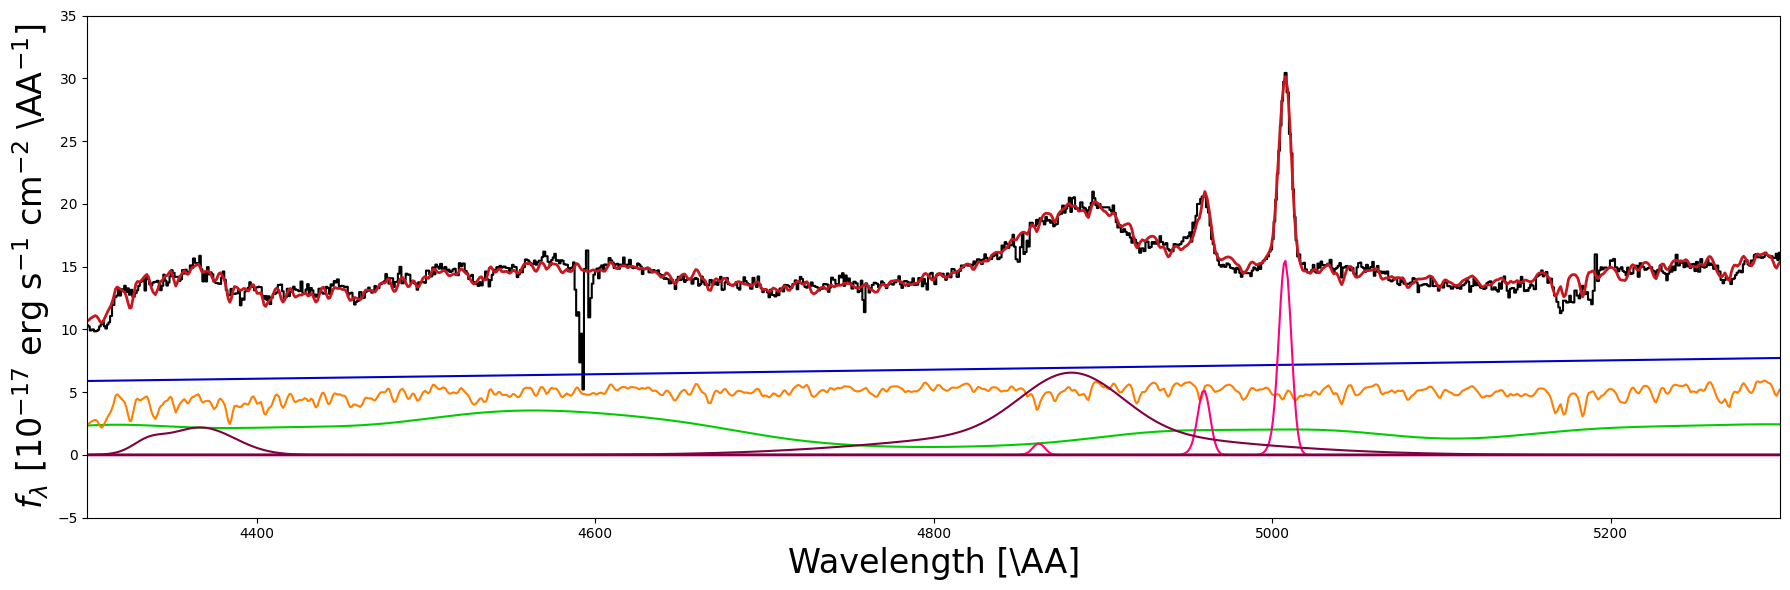

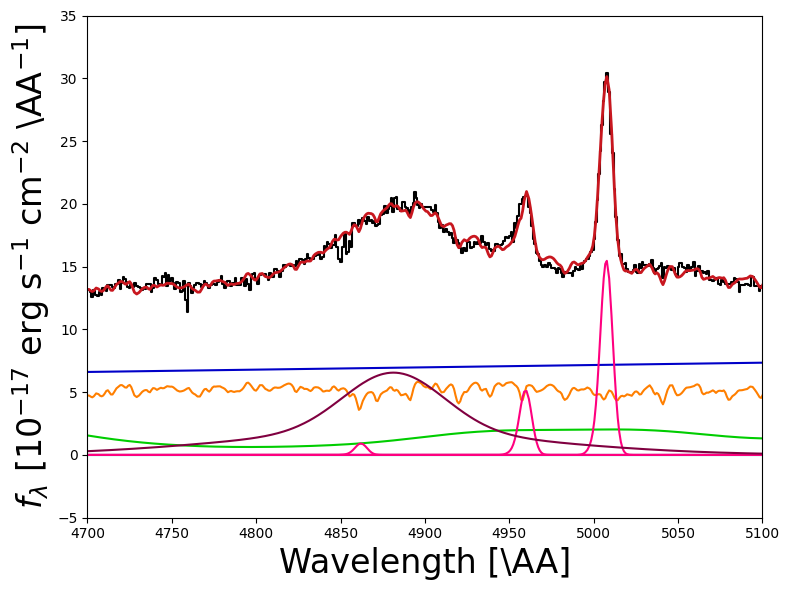

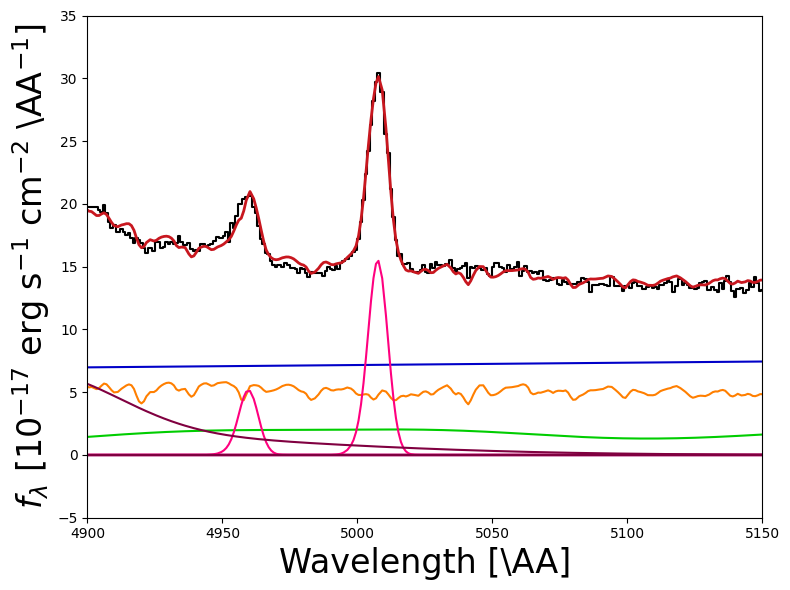

In [45]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)

wavemin = 3725.
wavemax = 5600.
ymin = -2
ymax = 60.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength [\AA]'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = 'hbeta'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,4300,5300,-5,35,'Wavelength [\AA]',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)